In [1]:
import numpy as np
import pandas as pd
from nilearn import datasets, image, plotting, input_data
from glob import glob
import os
import seaborn as sns

In [2]:
def cohens_d(i1, i2):
    """
    calculates cohens d for two images
    based on https://machinelearningmastery.com/effect-size-measures-in-python/
    """
    n1, n2 = i1.shape[-1], i2.shape[-1]
    s1 = np.var(i1, axis=-1, ddof=1)
    s2 = np.var(i2, axis=-1, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1 = np.mean(i1, axis=-1)
    u2 = np.mean(i2, axis=-1)
    d = (u1 - u2) / s
    return d

In [3]:
hc_ind = [False,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True, False,  True, False, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True,  True, False, False,
       False,  True, False,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True, False,  True,
        True,  True,  True, False, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True]
pat_ind = [ True, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False,  True, False,  True,  True, False, False, False,  True,
       False,  True, False, False,  True, False, False,  True,  True,
        True, False,  True, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True,  True, False, False,  True, False,  True, False,
       False, False, False,  True,  True, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False]

In [4]:
in_dir = '/Users/franzliem/Desktop/adni/in/'
out_dir = '/Users/franzliem/Desktop/adni/out'

brain_mask = datasets.load_mni152_brain_mask()
os.makedirs(out_dir, exist_ok=True)

#template = os.path.join(in_dir, "{subject_id}*{metric}.nii.gz")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


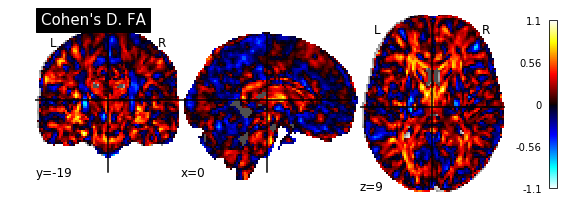

In [6]:
df = pd.DataFrame([])
for metric in ["FA"]:
    nii_file = os.path.join(in_dir, f"{metric}_all_subjects.nii")
    masker = input_data.NiftiMasker(mask_img=brain_mask)
    nii_masked = masker.fit_transform(nii_file)

    d = cohens_d(nii_masked[hc_ind,:].T, nii_masked[pat_ind,:].T)
    d_img = masker.inverse_transform(d)

    d_img.to_filename(os.path.join(out_dir, f"cohens_d_{metric}.nii.gz"))
    plotting.plot_stat_map(d_img, title=f"Cohen's D. {metric}")
    
    # save to df
    df_ = pd.DataFrame({"d": d})
    df_["metric"] = metric
    df = df.append(df_)

In [7]:
means = (df.groupby("metric").
         mean().
         sort_values(by="d").
         reset_index().reset_index().
         rename(columns={"index": "order"}).
         replace([np.inf, -np.inf], np.nan).
         dropna()
        )

df = (pd.merge(df, means[["metric", "order"]], on="metric").
      sort_values(by="order")
     )

In [8]:
print(means)

   order metric        d
0      0     FA  0.09777


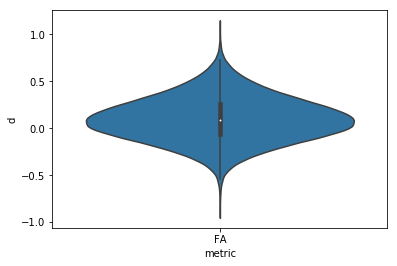

In [9]:
sns.violinplot(data=df, x="metric", y="d", title="Voxel-wise Cohen's d")